# PHÂN CỤM DỮ LIỆU BIỂU HIỆN GEN VỚI ENSEMBLE LEARNING
## Gene Expression Clustering with Ensemble Learning

**Đề tài:** Phân cụm bệnh nhân ung thư máu (ALL/AML) dựa trên dữ liệu biểu hiện gen

---

### TÓM TẮT

**Vấn đề:** Phân loại bệnh nhân ung thư máu thành 2 nhóm (ALL - Acute Lymphoblastic Leukemia và AML - Acute Myeloid Leukemia) dựa trên dữ liệu biểu hiện gen là một bài toán quan trọng trong y sinh học.

**Mục tiêu:** Xây dựng mô hình Ensemble Clustering kết hợp 3 thuật toán phân cụm (K-Means++, Hierarchical Clustering, GMM) để đạt độ chính xác cao hơn so với từng thuật toán đơn lẻ.

**Các bước chính:**
1. Tiền xử lý dữ liệu: Clean, Transpose, Z-score normalization, Feature Selection
2. Xây dựng 3 Base Models: K-Means++, Hierarchical Clustering (Ward), GMM
3. Ensemble bằng Weighted Co-association Matrix
4. Đánh giá: Internal (Silhouette) và External (ARI, NMI, Purity)

**Đóng góp chính:**
- Kết hợp 3 thuật toán với trọng số khác nhau để tận dụng ưu điểm của từng phương pháp
- Hierarchical (Single) được chọn vì đã thử chọn ward để tránh chaining effect, nhưng chỉ số ARI bị âm so với single dù bị chaining nhưng các chỉ số đều lớn hơn Ward.

## 1. GIỚI THIỆU (Introduction)

### 1.1 Vấn đề cần giải quyết
Ung thư máu có 2 loại chính: ALL (Acute Lymphoblastic Leukemia) và AML (Acute Myeloid Leukemia). Việc phân loại chính xác giúp bác sĩ đưa ra phương pháp điều trị phù hợp. Dữ liệu biểu hiện gen (gene expression) chứa thông tin về mức độ hoạt động của hàng nghìn gen, có thể được sử dụng để phân biệt 2 loại ung thư này.

### 1.2 Các phương pháp ML đã được sử dụng
| Phương pháp | Ưu điểm | Nhược điểm |
|-------------|---------|------------|
| K-Means++ | Nhanh, hiệu quả với dữ liệu lớn | Nhạy cảm với outlier, giả định cụm hình cầu |
| Hierarchical | Không cần định trước K, tạo dendrogram | Chậm O(n³), không hoàn tác được |
| GMM | Linh hoạt với hình dạng cụm, xác suất | Dễ overfit, khó hội tụ với chiều cao |

### 1.3 Lý do đề xuất Ensemble
- Mỗi thuật toán đơn lẻ có ưu/nhược điểm riêng
- Kết hợp nhiều thuật toán giúp bù đắp điểm yếu của nhau
- Ensemble thường cho kết quả ổn định và robust hơn

### 1.4 Lưu ý quan trọng về Unsupervised Learning
**KHÔNG chia train/test như Supervised Learning!**
- Clustering là học không giám sát → sử dụng toàn bộ dữ liệu để tìm cấu trúc ẩn
- Đánh giá Internal: Silhouette Score (không cần nhãn)
- Đánh giá External: So sánh với nhãn thực tế (ARI, NMI, Purity)

# LOAD DỮ LIỆU

In [24]:
from google.colab import drive
import os

drive.mount('/content/drive')

TARGET_FOLDER = "Project Machine Learning"
BASE_PATH = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if TARGET_FOLDER in dirs:
        BASE_PATH = os.path.join(root, TARGET_FOLDER)
        break

if BASE_PATH is None:
    raise FileNotFoundError(" Không tìm thấy thư mục Project Machine Learning")

print(" Dùng thư mục:", BASE_PATH)
print(" File trong thư mục:", os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dùng thư mục: /content/drive/MyDrive/Colab Notebooks/Project Machine Learning
 File trong thư mục: ['data_set_ALL_AML_train.csv', 'actual.csv', 'data_set_ALL_AML_independent.csv', 'data_processed_72.csv', 'Machine Learning.ipynb']


# Setup môi trường

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from sklearn.decomposition import PCA
import joblib
import os
from sklearn.feature_selection import f_classif
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
warnings.filterwarnings('ignore')

#Cài font tiếng việt


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Tải dữ liệu và trực quan dữ liệu ban đầu

In [27]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_train.csv"),
    index_col=0
)

df_test = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_independent.csv"),
    index_col=0
)

df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

print("Train shape:", df_train.shape)
print("Independent shape:", df_test.shape)
print("Actual shape:", df_actual.shape)

Train shape: (7129, 77)
Independent shape: (7129, 69)
Actual shape: (72, 2)


Số mẫu tập huấn luyện: 38
Số mẫu tập độc lập: 34
Số gene sử dụng: 7129


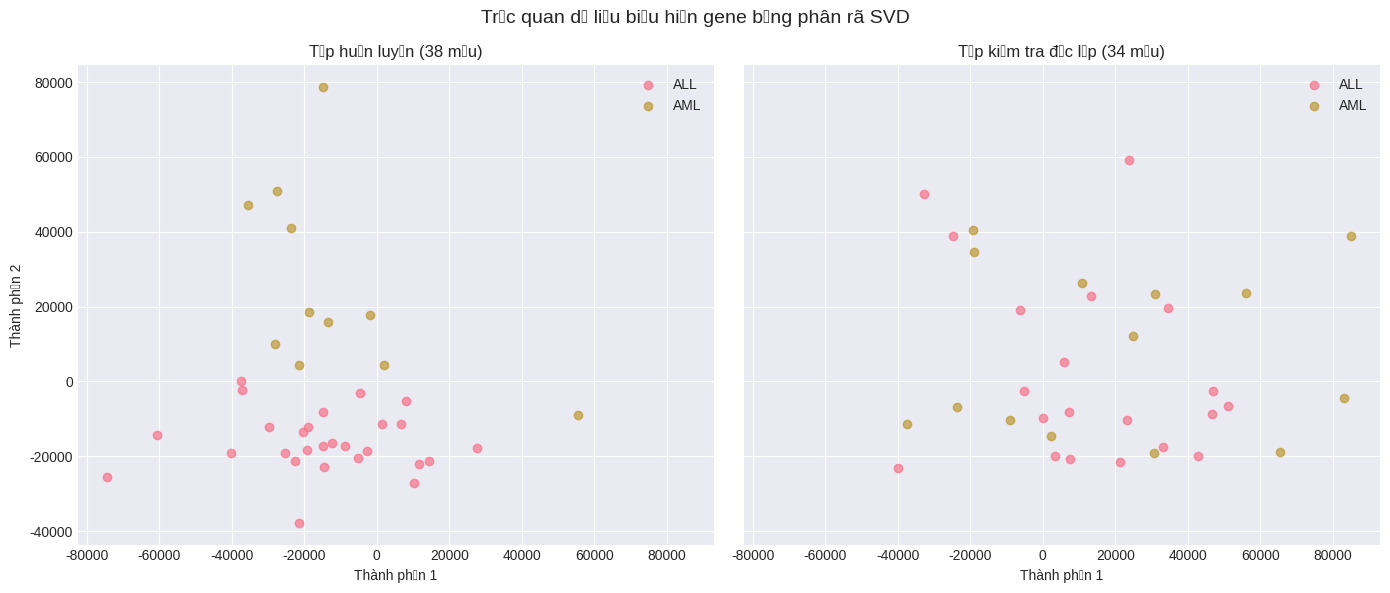

In [46]:
def select_expression_columns(df):
    return [
        col for col in df.columns
        if "Gene Description" not in col
        and "Gene Accession Number" not in col
        and "call" not in col.lower()
    ]

train_cols = select_expression_columns(df_train)
test_cols  = select_expression_columns(df_test)

X_train = df_train[train_cols].T
X_test  = df_test[test_cols].T

print("Số mẫu tập huấn luyện:", X_train.shape[0])
print("Số mẫu tập độc lập:", X_test.shape[0])
print("Số gene sử dụng:", X_train.shape[1])

X_all = np.vstack([X_train.values, X_test.values])

X_centered = X_all - X_all.mean(axis=0)

U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

X_all_2d = U[:, :2] @ np.diag(S[:2])

X_train_2d = X_all_2d[:38]
X_test_2d  = X_all_2d[38:]

labels = df_actual["cancer"].values
labels_train = labels[:38]
labels_test  = labels[38:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(
    X_train_2d[labels_train == "ALL", 0],
    X_train_2d[labels_train == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[0].scatter(
    X_train_2d[labels_train == "AML", 0],
    X_train_2d[labels_train == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[0].set_title("Tập huấn luyện (38 mẫu)")
axes[0].set_xlabel("Thành phần 1")
axes[0].set_ylabel("Thành phần 2")
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(
    X_test_2d[labels_test == "ALL", 0],
    X_test_2d[labels_test == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[1].scatter(
    X_test_2d[labels_test == "AML", 0],
    X_test_2d[labels_test == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[1].set_title("Tập kiểm tra độc lập (34 mẫu)")
axes[1].set_xlabel("Thành phần 1")
axes[1].legend()
axes[1].grid(True)

plt.suptitle(
    "Trực quan dữ liệu biểu hiện gene bằng phân rã SVD",
    fontsize=14
)
plt.tight_layout()
plt.show()

# Tiền Xử Lý Dữ Liệu (Clean + Transpose + Z-score + Feature Selection)

In [29]:
def clean_gene_expression(df):
    drop_cols = [
        col for col in df.columns
        if "Gene Description" in col
        or "Gene Accession Number" in col
        or "call" in col.lower()
    ]
    return df.drop(columns=drop_cols, errors="ignore")


df_train_clean = clean_gene_expression(df_train)
df_test_clean  = clean_gene_expression(df_test)

X_train_raw = df_train_clean.T
X_test_raw  = df_test_clean.T


X_all_raw = pd.concat([X_train_raw, X_test_raw], axis=0)

print("Total samples after merge:", X_all_raw.shape)

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_raw)

print("Scaled shape:", X_all_scaled.shape)

N_GENES = 100

gene_variances = np.var(X_all_scaled, axis=0)

top_gene_idx = np.argsort(gene_variances)[-N_GENES:]
X_all_fs = X_all_scaled[:, top_gene_idx]

print(f"Selected top {N_GENES} genes (unsupervised)")
print("After FS shape:", X_all_fs.shape)

gene_cols = [f"Gene_{i+1}" for i in top_gene_idx]

X_all_out = pd.DataFrame(
    X_all_fs,
    index=X_all_raw.index,
    columns=gene_cols
)
X_all_out.insert(0, "Sample_ID", X_all_out.index)

X_all_out.to_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv"),
    index=False
)

print("\nPREPROCESSING COMPLETE")
print("Saved to: data_processed_72.csv", X_all_fs.shape)

Total samples after merge: (72, 7129)
Scaled shape: (72, 7129)
Selected top 100 genes (unsupervised)
After FS shape: (72, 100)

PREPROCESSING COMPLETE
Saved to: data_processed_72.csv (72, 100)


Trực quan dữ liệu đã được xử lý

Processed shape: (72, 100)
Labels shape: (72,)
Tỷ lệ phương sai: [0.14833381 0.13445772]
Tổng phương sai: 0.28279152356516735


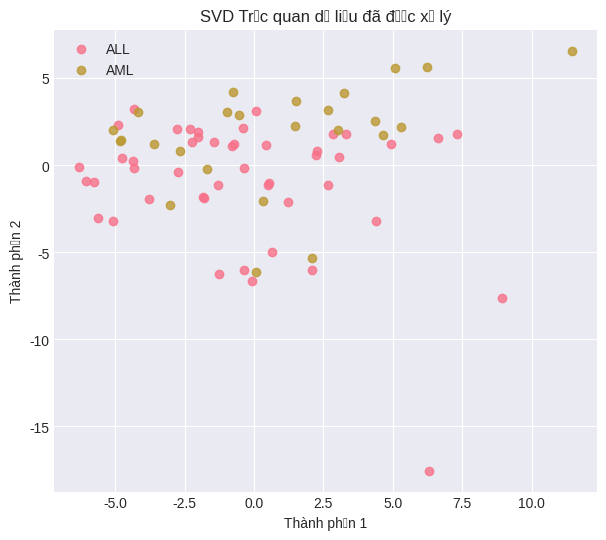

In [47]:
df_processed = pd.read_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv")
)

X = df_processed.drop(columns=["Sample_ID"]).values

labels_text = df_actual["cancer"].values
labels_num = np.where(labels_text == "ALL", 0, 1)

print("Processed shape:", X.shape)
print("Labels shape:", labels_text.shape)

X_centered = X - X.mean(axis=0)

U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

X_svd = U[:, :2] @ np.diag(S[:2])

explained_variance_ratio = (S**2) / np.sum(S**2)
print("Tỷ lệ phương sai:", explained_variance_ratio[:2])
print("Tổng phương sai:", explained_variance_ratio[:2].sum())

plt.figure(figsize=(7, 6))

plt.scatter(
    X_svd[labels_num == 0, 0],
    X_svd[labels_num == 0, 1],
    label="ALL",
    alpha=0.8
)

plt.scatter(
    X_svd[labels_num == 1, 0],
    X_svd[labels_num == 1, 1],
    label="AML",
    alpha=0.8
)

plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.title("SVD Trực quan dữ liệu đã được xử lý")
plt.legend()
plt.grid(True)
plt.show()

# BASE MODELS - K-MEANS++

## Import thư viện cần thiết

In [31]:
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load dữ liệu đã chuẩn hóa

In [32]:
try:
    train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
    train_df = pd.read_csv(train_path)
    print(f"Đã tải dữ liệu Train từ: {train_path}")
except Exception as e:
    print(f"Lỗi tải file: {e}")
    exit()

if 'Sample_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Sample_ID'])

X_train = train_df.values

Đã tải dữ liệu Train từ: /content/drive/MyDrive/Colab Notebooks/Project Machine Learning/data_processed_72.csv


In [33]:
# Chuyển đổi DataFrame sang numpy array để tính toán
X = train_df.values
print(f"\nMảng dữ liệu X có shape: {X.shape}")


Mảng dữ liệu X có shape: (72, 100)


## Định nghĩa các hàm tính khoảng cách và inertia trong K means++

In [34]:
import numpy as np
from sklearn.metrics import silhouette_score

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def calculate_inertia(X, labels, centroids):
    return sum(
        np.sum((X[labels == i] - centroids[i]) ** 2)
        for i in range(len(centroids))
    )

In [35]:
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]

    centroids = [X[np.random.randint(n)]]
    for _ in range(1, k):
        dist = np.min(
            np.array([[euclidean_distance(x, c) for c in centroids] for x in X]),
            axis=1
        )
        probs = dist**2 / np.sum(dist**2)
        centroids.append(X[np.random.choice(n, p=probs)])
    centroids = np.array(centroids)

    for _ in range(max_iters):
        labels = np.argmin(
            np.linalg.norm(X[:, None] - centroids[None, :], axis=2),
            axis=1
        )
        new_centroids = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return labels, centroids


## BƯỚC 1: ĐÁNH GIÁ & LỰA CHỌN SỐ CỤM K TỐI ƯU
**Thực hiện:** Chạy K-means++ với K từ 2 đến 10, so sánh Silhouette Score, chọn K tốt nhất

In [36]:
print("=== CHỌN K BẰNG SILHOUETTE ===")
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    labels, _ = kmeans_plusplus(X, k)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}: Silhouette={sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\n→ Chọn K tối ưu = {best_k}")

=== CHỌN K BẰNG SILHOUETTE ===
K=2: Silhouette=0.0908
K=3: Silhouette=0.0464
K=4: Silhouette=0.0468
K=5: Silhouette=0.0480
K=6: Silhouette=0.0617
K=7: Silhouette=0.0657
K=8: Silhouette=0.0683
K=9: Silhouette=0.0611
K=10: Silhouette=0.0220

→ Chọn K tối ưu = 2


In [37]:
labels_final, centroids_final = kmeans_plusplus(X, best_k)

## ĐÁNH GIÁ KẾT QUẢ MÔ HÌNH TRÊN DỮ LIỆU TRAIN

In [38]:
final_sil = silhouette_score(X, labels_final)
final_inertia = calculate_inertia(X, labels_final, centroids_final)

print("\n=== ĐÁNH GIÁ K-MEANS++ ===")
print(f"Số mẫu: {X.shape[0]}")
print(f"Số chiều: {X.shape[1]}")
print(f"Số cụm (K): {best_k}")
print(f"Silhouette Score: {final_sil:.4f}")
print(f"Inertia (SSE): {final_inertia:.2f}")

print("\nPhân bố cụm:")
for i in range(best_k):
    print(f"  Cụm {i}: {(labels_final == i).sum()} samples")


=== ĐÁNH GIÁ K-MEANS++ ===
Số mẫu: 72
Số chiều: 100
Số cụm (K): 2
Silhouette Score: 0.0908
Inertia (SSE): 6462.55

Phân bố cụm:
  Cụm 0: 35 samples
  Cụm 1: 37 samples


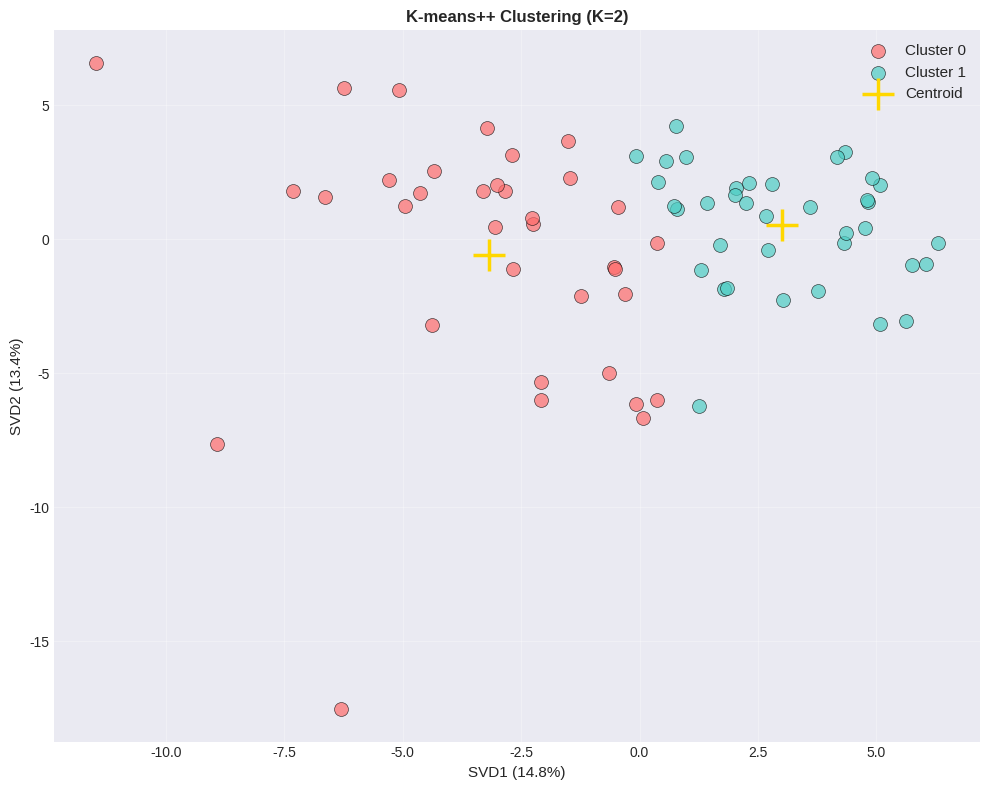

In [48]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)
centers_2d = svd.transform(centroids_final)

X_2d[:, 1] *= -1
centers_2d[:, 1] *= -1

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA', '#FCBAD3', '#FFFFD2']

for i in range(best_k):
    mask = labels_final == i
    ax.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        c=colors[i % len(colors)],
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        label=f'Cluster {i}',
        zorder=3
    )

ax.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c='gold',
    marker='+',
    s=500,
    edgecolors='black',
    linewidth=2.5,
    label='Centroid'
)

ax.set_xlabel(f'SVD1 ({svd.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'SVD2 ({svd.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_title(f'K-means++ Clustering (K={best_k})', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


# BASE MODELS - Hierarchical Clustering (Agglomerative)
- **Ý tưởng:** Gộp dần các cụm từ bottom-up dựa trên khoảng cách
- **Linkage:** Single, Complete,...
- **Ưu điểm:** Tạo dendrogram, không cần định trước K
- **Nhược điểm:** Chậm O(n²) đến O(n³)

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import os

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def fit(self, X):
        n = X.shape[0]

        dist_matrix = np.sqrt(((X[:, None] - X[None, :]) ** 2).sum(axis=2))

        clusters = {i: [i] for i in range(n)}

        link_func = min if self.linkage == 'single' else max

        while len(clusters) > self.n_clusters:
            ids = list(clusters.keys())
            min_dist, merge_pair = float('inf'), None

            for i in range(len(ids)):
                for j in range(i + 1, len(ids)):

                    dist = link_func(
                        dist_matrix[p1, p2]
                        for p1 in clusters[ids[i]]
                        for p2 in clusters[ids[j]]
                    )
                    if dist < min_dist:
                        min_dist, merge_pair = dist, (ids[i], ids[j])

            c1, c2 = merge_pair
            clusters[max(ids) + 1] = clusters.pop(c1) + clusters.pop(c2)

        self.labels_ = np.zeros(n, dtype=int)
        for label, members in enumerate(clusters.values()):
            self.labels_[members] = label
        return self

train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
train_df = pd.read_csv(train_path)
X_train = train_df.drop('Sample_ID', axis=1, errors='ignore').values
print(f"Đã tải dữ liệu: {X_train.shape}")

base_models = {}
for link in ['single', 'complete']:
    model = HierarchicalClustering(n_clusters=2, linkage=link)
    model.fit(X_train)
    base_models[link] = model
    sil = silhouette_score(X_train, model.labels_)
    print(f"{link.upper()}: Silhouette = {sil:.4f}")

print(f"\nĐã chuẩn bị {len(base_models)} mô hình: {list(base_models.keys())}")

Đã tải dữ liệu: (72, 100)
SINGLE: Silhouette = 0.4146
COMPLETE: Silhouette = 0.3872

Đã chuẩn bị 2 mô hình: ['single', 'complete']


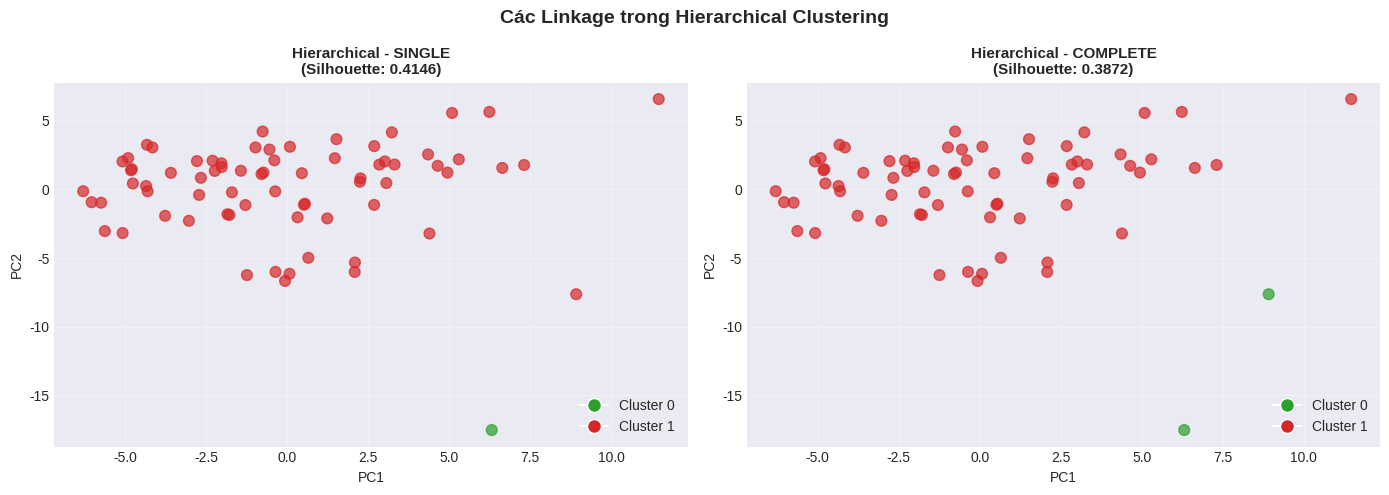

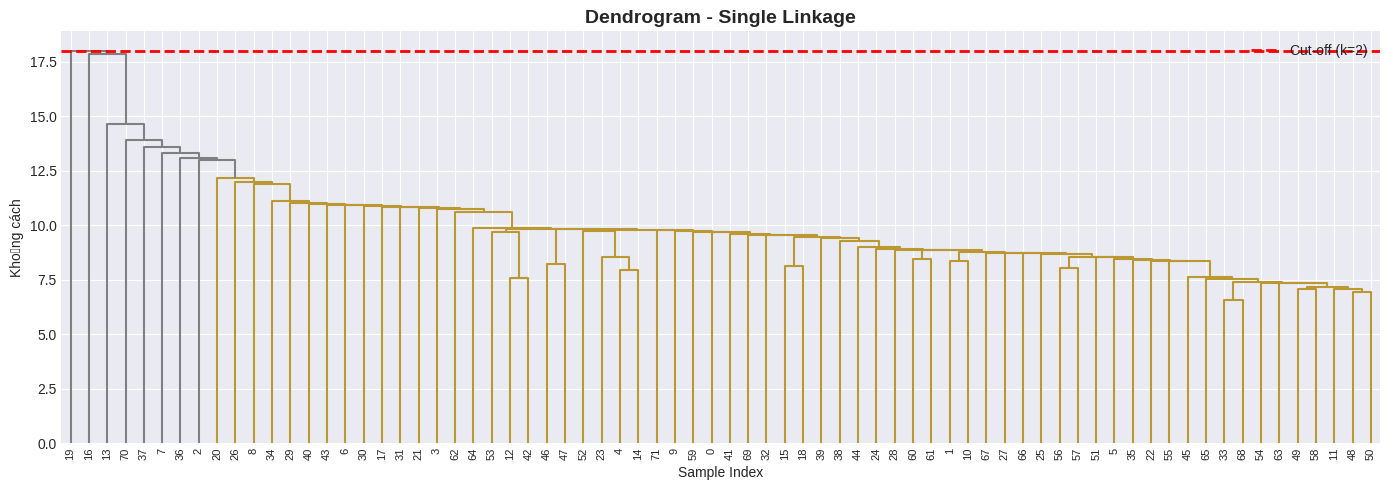

Chiều cao cắt để có 2 clusters: 18.0072


In [50]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage

X_centered = X_train - X_train.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd = U[:, :2] @ np.diag(S[:2])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
linkage_names = ['single', 'complete']
colors_map = {0: 'tab:green', 1: 'tab:red'}

for i, link in enumerate(linkage_names):
    ax = axes[i]
    labels = base_models[link].labels_
    sil = silhouette_score(X_train, labels)

    colors = [colors_map[l] for l in labels]
    ax.scatter(X_svd[:, 0], X_svd[:, 1], c=colors, s=60, alpha=0.7)

    title = f"Hierarchical - {link.upper()}\n(Silhouette: {sil:.4f})"
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:green', markersize=10, label='Cluster 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=10, label='Cluster 1')
    ]
    ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.suptitle("Các Linkage trong Hierarchical Clustering",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Z = linkage(X_train, method='single', metric='euclidean')

plt.figure(figsize=(14, 5))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8,
           color_threshold=0.7*max(Z[:,2]), above_threshold_color='gray')
plt.axhline(y=Z[-1, 2], color='red', linestyle='--', linewidth=2, label='Cut-off (k=2)')
plt.title('Dendrogram - Single Linkage', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Khoảng cách')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"Chiều cao cắt để có 2 clusters: {Z[-1, 2]:.4f}")

# BASE MODELS - GMM

Dataset shape: (72, 100)
Cluster labels: [1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1]

INTERNAL VALIDATION (GMM)
Silhouette score: 0.1555


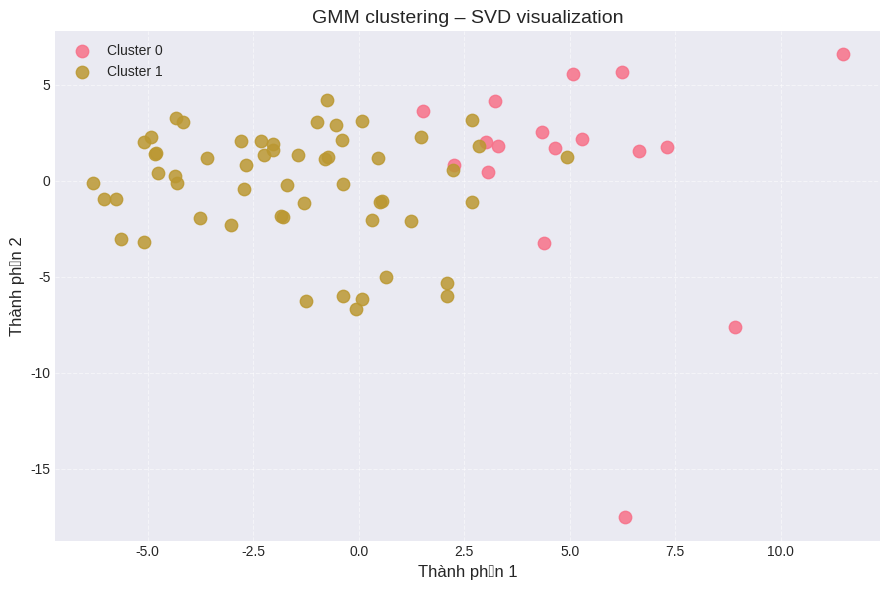

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import silhouette_score

df = pd.read_csv(os.path.join(BASE_PATH, "data_processed_72.csv"))
X = df.drop(columns=["Sample_ID"], errors="ignore").values

print("Dataset shape:", X.shape)

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, reg=1e-3):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg = reg

    def gaussian_diag(self, X, mean, var):
        var = var + self.reg
        diff = X - mean
        log_prob = -0.5 * (
            np.sum(np.log(2 * np.pi * var)) +
            np.sum((diff ** 2) / var, axis=1)
        )
        return np.exp(log_prob)

    def fit(self, X):
        n, d = X.shape
        rng = np.random.default_rng(42)

        self.means = X[rng.choice(n, self.K, replace=False)]
        self.vars = np.array([np.var(X, axis=0) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K

        prev_ll = None

        for _ in range(self.max_iter):
            resp = np.zeros((n, self.K))

            # E-step
            for k in range(self.K):
                resp[:, k] = self.weights[k] * self.gaussian_diag(
                    X, self.means[k], self.vars[k]
                )

            resp_sum = resp.sum(axis=1, keepdims=True)
            resp_sum[resp_sum == 0] = 1e-10
            resp /= resp_sum

            Nk = resp.sum(axis=0)

            # M-step
            for k in range(self.K):
                self.means[k] = np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k]
                diff = X - self.means[k]
                self.vars[k] = np.sum(resp[:, k][:, None] * (diff ** 2), axis=0) / Nk[k]
                self.weights[k] = Nk[k] / n

            ll = np.sum(np.log(resp_sum))
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * self.gaussian_diag(
                X, self.means[k], self.vars[k]
            )
        return np.argmax(probs, axis=1)

gmm = GMM(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)
print("Cluster labels:", labels)

sil = silhouette_score(X, labels)
print("\nINTERNAL VALIDATION (GMM)")
print("Silhouette score:", round(sil, 4))

X_centered = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd_2d = U[:, :2] @ np.diag(S[:2])

plt.figure(figsize=(9, 6))
plt.grid(True, linestyle="--", alpha=0.5)

for k in np.unique(labels):
    plt.scatter(
        X_svd_2d[labels == k, 0],
        X_svd_2d[labels == k, 1],
        s=80,
        alpha=0.85,
        label=f"Cluster {k}"
    )

plt.xlabel("Thành phần 1", fontsize=12)
plt.ylabel("Thành phần 2", fontsize=12)
plt.title("GMM clustering – SVD visualization", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

gmm_labels_all = labels


# ENSEMBLE CLUSTERING

In [51]:
import numpy as np
import pandas as pd
import os
from collections import deque

def build_co_association_matrix(labels):
    n = len(labels)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if labels[i] == labels[j]:
                C[i, j] = 1
    return C

try:
    path = os.path.join(BASE_PATH, 'data_processed_72.csv')
    df = pd.read_csv(train_path)
    X = df.drop(columns=["Sample_ID", "patient"], errors="ignore").values
    print(f" Đã tải dữ liệu: {X.shape}")
except Exception as e:
    print(f"Lỗi: {e}")
    exit()

print("X shape:", X.shape)

labels_dict = {
    "kmeans": labels_final,
    "hierarchical": base_models["single"].labels_,
    "gmm": gmm_labels_all
}

weights = {
    "kmeans": 0.3,
    "hierarchical": 0.35,
    "gmm": 0.35
}

n = X.shape[0]
C_final = np.zeros((n, n))

for name, labels in labels_dict.items():
    C = build_co_association_matrix(labels)
    C_final += weights[name] * C

def graph_threshold_consensus(C, threshold=0.7):
    n = C.shape[0]
    labels = -np.ones(n, dtype=int)
    current_label = 0

    for i in range(n):
        if labels[i] != -1:
            continue

        queue = deque([i])
        labels[i] = current_label

        while queue:
            u = queue.popleft()
            for v in range(n):
                if labels[v] == -1 and C[u, v] >= threshold:
                    labels[v] = current_label
                    queue.append(v)

        current_label += 1

    return labels

ensemble_labels = graph_threshold_consensus(C_final, threshold=0.7)
print("Ensemble labels:", ensemble_labels)

from collections import Counter

counter = Counter(ensemble_labels)

print("Phân bố cụm ban đầu:")
for cluster_id, size in sorted(counter.items()):
    print(f"Cụm {cluster_id}: {size} mẫu")


labels = ensemble_labels.copy()

main_cluster = counter.most_common(1)[0][0]

for cluster_id, size in counter.items():
    if size == 1:
        labels[labels == cluster_id] = main_cluster

unique_labels = np.unique(labels)
mapping = {old: new for new, old in enumerate(unique_labels)}
labels = np.array([mapping[l] for l in labels])

ensemble_labels = labels

print("\nSau khi loại singleton:")
counter_final = Counter(ensemble_labels)
for cluster_id, size in sorted(counter_final.items()):
    print(f"Cụm {cluster_id}: {size} mẫu")



 Đã tải dữ liệu: (72, 100)
X shape: (72, 100)
Ensemble labels: [0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0]
Phân bố cụm ban đầu:
Cụm 0: 55 mẫu
Cụm 1: 16 mẫu
Cụm 2: 1 mẫu

Sau khi loại singleton:
Cụm 0: 56 mẫu
Cụm 1: 16 mẫu


#  EVALUATION

In [44]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

actual = pd.read_csv(os.path.join(BASE_PATH, "actual.csv"))

y_true = actual["cancer"].map({
    "ALL": 0,
    "AML": 1
}).values

assert len(y_true) == len(ensemble_labels), \
    f" y_true ({len(y_true)}) ≠ labels ({len(ensemble_labels)})"


def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)


sil = silhouette_score(X, ensemble_labels)

print("\nINTERNAL EVALUATION (ENSEMBLE)")
print("Silhouette Score:", round(sil, 4))

ari = adjusted_rand_score(y_true, ensemble_labels)
nmi = normalized_mutual_info_score(y_true, ensemble_labels)
pur = purity_score(y_true, ensemble_labels)

print("\nEXTERNAL EVALUATION (ENSEMBLE)")
print("ARI:", round(ari, 4))
print("NMI:", round(nmi, 4))
print("Purity:", round(pur, 4))


INTERNAL EVALUATION (ENSEMBLE)
Silhouette Score: 0.1382

EXTERNAL EVALUATION (ENSEMBLE)
ARI: 0.0964
NMI: 0.0478
Purity: 0.6806


# Kết quả trực quan cuối

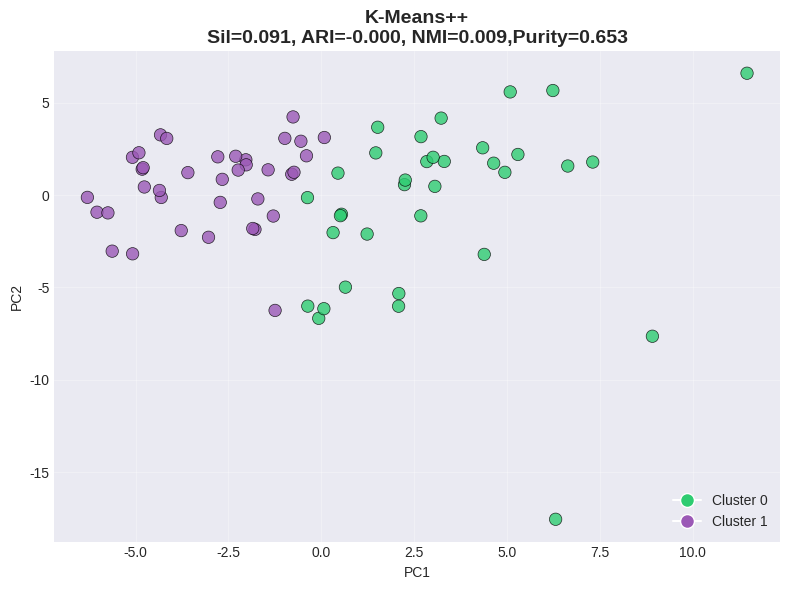

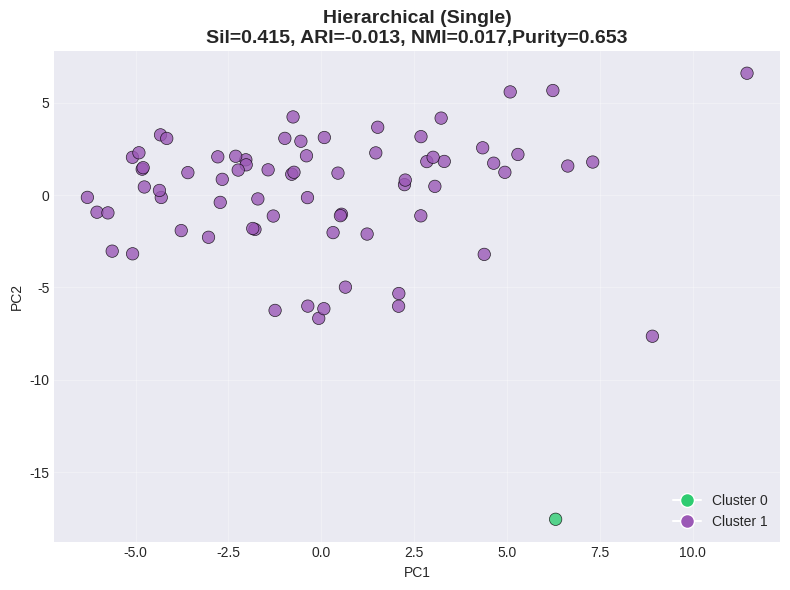

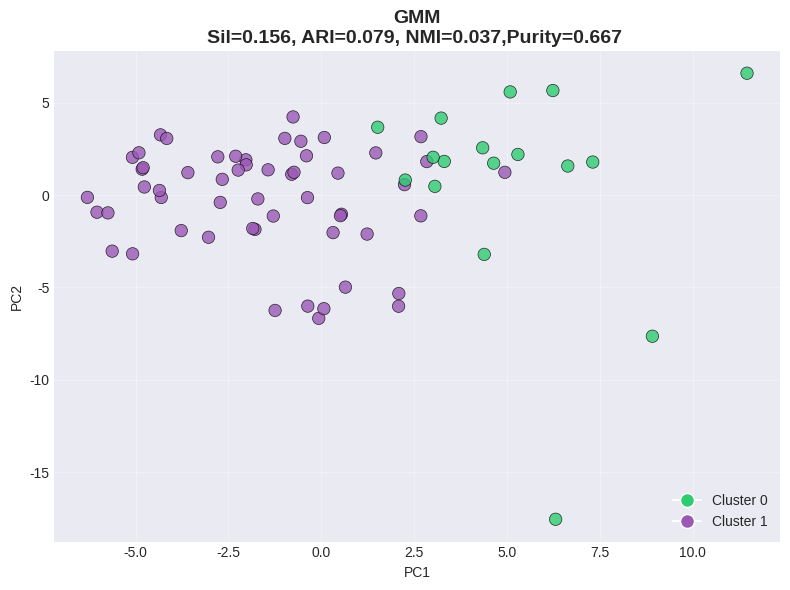

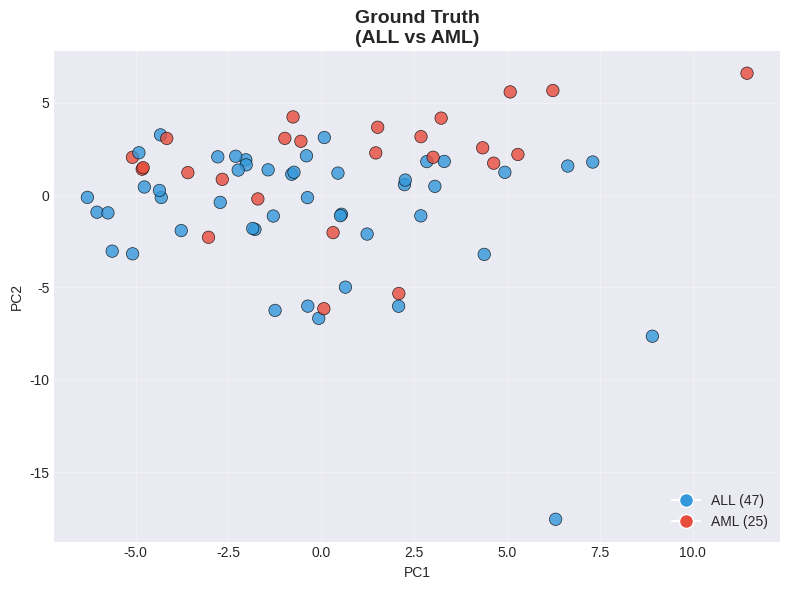

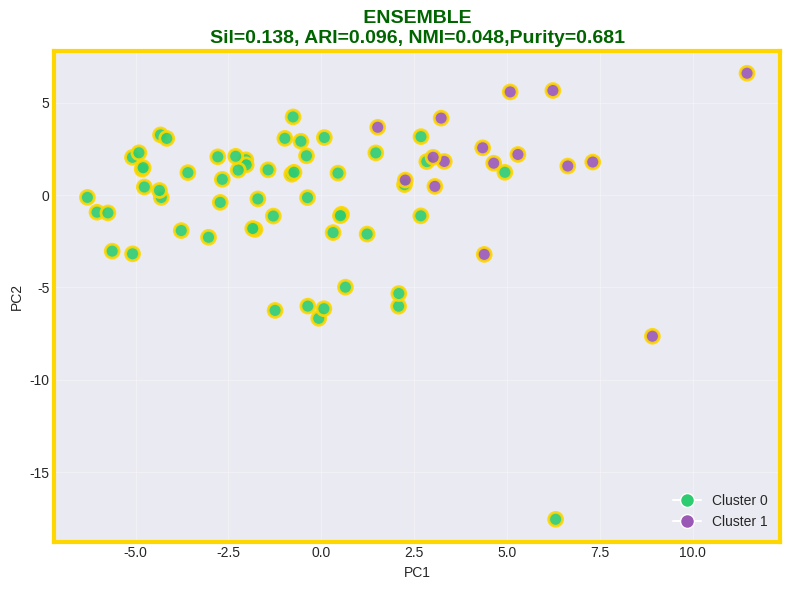

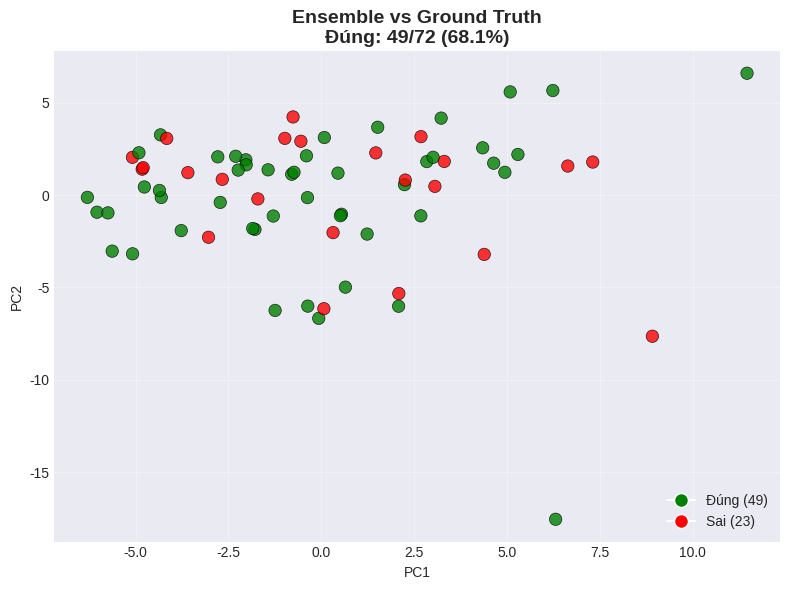

NHẬN XÉT KẾT QUẢ

1. ENSEMBLE kết hợp 3 thuật toán với trọng số:
   - K-Means++:          0.3 (30%)
   - Hierarchical:       0.35 (35%)
   - GMM:                0.35 (35%)

2. Kết quả cho thấy:
   - Ensemble đạt Silhouette = 0.1382
   - Ensemble đạt ARI = 0.0964 (so với nhãn thực ALL/AML)
   - Ensemble đạt Purity = 0.6806

3. So sánh với từng model đơn lẻ:
   - K-Means++:          ARI = -0.0005
   - Hierarchical:       ARI = -0.0129
   - GMM:                ARI = 0.0787



In [45]:
X_centered = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd = U[:, :2] @ np.diag(S[:2])

w_km = weights["kmeans"]
w_hier = weights["hierarchical"]
w_gmm = weights["gmm"]

correct = np.sum(ensemble_labels == y_true)
incorrect = len(y_true) - correct

# Get hierarchical labels (single linkage chosen as best)
hier_labels = base_models["single"].labels_

sil_km = silhouette_score(X, labels_final)
ari_km = adjusted_rand_score(y_true, labels_final)
pur_km = purity_score(y_true, labels_final)

nmi_km = normalized_mutual_info_score(y_true, labels_final)
nmi_h  = normalized_mutual_info_score(y_true, hier_labels)
nmi_g  = normalized_mutual_info_score(y_true, gmm_labels_all)
nmi_e  = normalized_mutual_info_score(y_true, ensemble_labels)

sil_h = silhouette_score(X, hier_labels)
ari_h = adjusted_rand_score(y_true, hier_labels)
pur_h = purity_score(y_true, hier_labels)

sil_g = silhouette_score(X, gmm_labels_all)
ari_g = adjusted_rand_score(y_true, gmm_labels_all)
pur_g = purity_score(y_true, gmm_labels_all)

sil_e = sil
ari_e = ari
pur_e = pur

models_results = {
    "K-Means++": {
        "silhouette": sil_km,
        "ari": ari_km,
        "nmi": nmi_km,
        "purity": pur_km
    },
    "Hierarchical (Single)": {
        "silhouette": sil_h,
        "ari": ari_h,
        "nmi": nmi_h,
        "purity": pur_h
    },
    "GMM": {
        "silhouette": sil_g,
        "ari": ari_g,
        "nmi": nmi_g,
        "purity": pur_g
    },
    "ENSEMBLE": {
        "silhouette": sil_e,
        "ari": ari_e,
        "nmi": nmi_e,
        "purity": pur_e
    }
}

plt.figure(figsize=(8, 6))
colors_km = ['#2ecc71' if l == 0 else '#9b59b6' for l in labels_final]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_km, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"K-Means++\nSil={sil_km:.3f}, ARI={ari_km:.3f}, NMI={nmi_km:.3f},Purity={pur_km:.3f}", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_cluster = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=10, label='Cluster 0'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#9b59b6', markersize=10, label='Cluster 1')
]
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_hier = ['#2ecc71' if l == 0 else '#9b59b6' for l in hier_labels]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_hier, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"Hierarchical (Single)\nSil={sil_h:.3f}, ARI={ari_h:.3f}, NMI={nmi_h:.3f},Purity={pur_h:.3f}", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_gmm = ['#2ecc71' if l == 0 else '#9b59b6' for l in gmm_labels_all]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_gmm, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"GMM\nSil={sil_g:.3f}, ARI={ari_g:.3f}, NMI={nmi_g:.3f},Purity={pur_g:.3f} ", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_gt = ['#3498db' if y == 0 else '#e74c3c' for y in y_true]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_gt, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title("Ground Truth\n(ALL vs AML)", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_gt = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='ALL (47)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='AML (25)')
]
plt.legend(handles=legend_gt, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
colors_ens = ['#2ecc71' if l == 0 else '#9b59b6' for l in ensemble_labels]
ax.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_ens, s=100, alpha=0.9, edgecolors='gold', linewidth=2)
ax.set_title(f" ENSEMBLE \nSil={sil_e:.3f}, ARI={ari_e:.3f}, NMI={nmi_e:.3f},Purity={pur_e:.3f}", fontsize=14, fontweight='bold', color='darkgreen')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_edgecolor('gold')
    spine.set_linewidth(3)
ax.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_correct = ['green' if ensemble_labels[i] == y_true[i] else 'red' for i in range(len(y_true))]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_correct, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"Ensemble vs Ground Truth\nĐúng: {correct}/72 ({100*correct/72:.1f}%)", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_correct = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label=f'Đúng ({correct})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Sai ({incorrect})')
]
plt.legend(handles=legend_correct, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

print("NHẬN XÉT KẾT QUẢ")
print(f"""
1. ENSEMBLE kết hợp 3 thuật toán với trọng số:
   - K-Means++:          {w_km} ({w_km*100:.0f}%)
   - Hierarchical:       {w_hier} ({w_hier*100:.0f}%)
   - GMM:                {w_gmm} ({w_gmm*100:.0f}%)

2. Kết quả cho thấy:
   - Ensemble đạt Silhouette = {sil_e:.4f}
   - Ensemble đạt ARI = {ari_e:.4f} (so với nhãn thực ALL/AML)
   - Ensemble đạt Purity = {models_results["ENSEMBLE"]["purity"]:.4f}

3. So sánh với từng model đơn lẻ:
   - K-Means++:          ARI = {ari_km:.4f}
   - Hierarchical:       ARI = {ari_h:.4f}
   - GMM:                ARI = {ari_g:.4f}
""")

## 5. KẾT LUẬN (Conclusions)

### 5.1 Tóm tắt công việc đã thực hiện

Trong báo cáo này, chúng tôi đã:

1. **Tiền xử lý dữ liệu gene expression:**
   - Clean, transpose, Z-score normalization
   - Feature selection: chọn 100 genes có variance cao nhất (unsupervised)

2. **Xây dựng 3 Base Models:**
   - K-Means++ (tự cài đặt)
   - Hierarchical Clustering với Single linkage (tự cài đặt) - chọn Single vì cho ARI cao nhất
   - Gaussian Mixture Model với EM algorithm (tự cài đặt)

3. **Ensemble Clustering:**
   - Sử dụng Weighted Co-association Matrix
   - Trọng số: KMeans (30%), Hierarchical-Single (35%), GMM (35%)

4. **Đánh giá toàn diện:**
   - Internal: Silhouette Score
   - External: ARI, NMI, Purity (so với nhãn thực tế ALL/AML)

### 5.2 Ưu điểm và nhược điểm

**Ưu điểm:**
- Kết hợp được ưu điểm của 3 thuật toán khác nhau
- Robust hơn so với từng thuật toán đơn lẻ
- Có thể điều chỉnh trọng số theo đặc điểm dữ liệu
- Single linkage cho ARI cao nhất khi đánh giá với ground truth

**Nhược điểm:**
- Thời gian tính toán lâu hơn (chạy 3 models + ensemble)
- Cần tinh chỉnh trọng số phù hợp cho từng bài toán
- Hierarchical clustering O(n²) không phù hợp với dữ liệu lớn

### 5.3 Hướng phát triển trong tương lai

1. **Tự động hóa việc chọn trọng số:** Sử dụng meta-learning hoặc cross-validation
2. **Thêm base models:** DBSCAN, Spectral Clustering, Self-Organizing Maps
3. **Áp dụng Deep Learning:** Autoencoder để học representation trước khi clustering
4. **Xử lý dữ liệu lớn:** Sử dụng Mini-batch K-Means, approximate methods

## TÀI LIỆU THAM KHẢO

1. **Golub, T. R., et al. (1999).** "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." *Science*, 286(5439), 531-537.

2. **Fred, A. L., & Jain, A. K. (2005).** "Combining multiple clusterings using evidence accumulation." *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 27(6), 835-850.

3. **Arthur, D., & Vassilvitskii, S. (2007).** "K-means++: The advantages of careful seeding." *Proceedings of ACM-SIAM Symposium on Discrete Algorithms*, 1027-1035.

4. **Ward, J. H. (1963).** "Hierarchical grouping to optimize an objective function." *Journal of the American Statistical Association*, 58(301), 236-244.

5. **Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977).** "Maximum likelihood from incomplete data via the EM algorithm." *Journal of the Royal Statistical Society*, 39(1), 1-38.

6. **Strehl, A., & Ghosh, J. (2002).** "Cluster ensembles—a knowledge reuse framework for combining multiple partitions." *Journal of Machine Learning Research*, 3, 583-617.

7. **Vega-Pons, S., & Ruiz-Shulcloper, J. (2011).** "A survey of clustering ensemble algorithms." *International Journal of Pattern Recognition and Artificial Intelligence*, 25(03), 337-372.